In [54]:
import requests
import pandas as pd
import plotly.express as px
import textblob as tb

In [55]:
def get_reddit_data(data_type, **kwargs):
    #data_type can be 'comment' or 'submission'
    base_url = f'https://api.pushshift.io/reddit/search/{data_type}/'
    payload = kwargs
    request = requests.get(base_url, params = payload)
    
    return request.json()

In [56]:
def make_clickable(val):
    return '<a href="{}">Link</a>'.format(val, val)

Global vars

In [83]:
COMMENT_COLOR         = 'blueviolet'
TERM_OF_INTEREST      = 'python'
SUBREDDIT_OF_INTEREST = 'python'
TIMEFRAME             = '2d'

Example query of the reddit api function

In [84]:
data = get_reddit_data(data_type = 'comment',
                          q = TERM_OF_INTEREST,
                          after = TIMEFRAME,
                          size = 1000,
                          aggs = 'subreddit')

In [85]:
data_agg = data.get('aggs').get('subreddit')
df = pd.DataFrame.from_records(data_agg)[0:10]

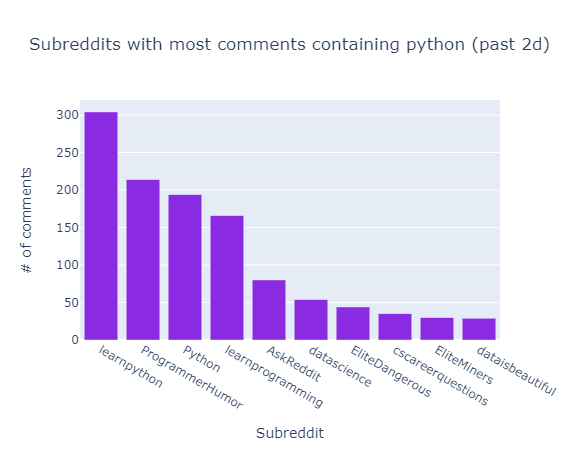

In [86]:
px.bar(df, x = 'key', y = 'doc_count', title = f'Subreddits with most comments containing {TERM_OF_INTEREST} (past {TIMEFRAME})',
      labels = {'doc_count': '# of comments', 'key': 'Subreddit'},
      color_discrete_sequence = [COMMENT_COLOR])

Sample query to find most upvoted comments including python

In [87]:
data2 = get_reddit_data(data_type = 'comment',
                          q = TERM_OF_INTEREST,
                          after = TIMEFRAME,
                          size = 10,
                          sort_type = 'score',
                       sort = 'desc').get('data')

In [88]:
df2 = pd.DataFrame.from_records(data2)[['author', 'subreddit', 'score', 'body', 'permalink']]
df2['body'] = df2['body'].str[0:400] + '...'
df2['permalink'] = 'https://reddit.com' + df2['permalink'].astype(str)
df2.style.format({'permalink': make_clickable})

,author,subreddit,score,body,permalink
0,Battlemage88,videos,437,Like a Monty Python Sketch in real life....,Link
1,NMe84,ProgrammerHumor,333,I'm not sure Python has much right to speak here with the v2 vs v3 mess they created and support....,Link
2,weluckyfew,todayilearned,329,"Important to note he was a lot more than just a Monty Python member - he has directed 14 movies, and his 80s 'trilogy' (Time Bandits, Brazil, and Adventures of Baron Munchausen) are considered some of the best fantasy/sci fi films ever made....",Link
3,plentity,Coronavirus,288,"Also 27 here. Completed a degree that was a “semi-safe bet” and had provided cool, stable and decently paid jobs to boomers and gen-xers. 2008 hit hard and I never found a job in my field, not even internships or unpaid opportunities. I speak 5 languages, I can do text analysis in R and Python and I am a childcare assistant. My “way out” of job insecurity is getting another degree in early chi...",Link
4,sdoc86,ProgrammerHumor,211,I use both daily. For very different things. Personally I could never use python for anything other than little data science and ML projects. I don’t trust myself enough. But I’m sure good python programmers could build successful large projects. I’m just not there yet....,Link
5,shiva_codes,learnprogramming,178,That's totally me .I made this mistake i got stuck in this tutorial loop.Once you learnt something FFS you apply it and learn it. Writing fibonacci series code and running it and seeing output on terminal made me sick. I learnt python moved on .Binged watched a web tutorial i did code along. But after that without building a thing i moved on to ML. I realized that I've gotten intl a loop. Then ...,Link
6,weelenny,gifsthatkeepongiving,132,It’s like a Monty Python sketch....,Link
7,801_chan,HistoryMemes,114,"They may not believe it because the rest of the world makes fun of them, but a lot of America finds Australian dialects sexy. Of all the things I learned in linguistics undergrad, the idea that other countries shit on Australia was bewildering. Steve Irwin glistening with sweat, all bare biceps and a python wrapped around his shoulders, I mean *hot damn*....",Link
8,Aurecon,ProgrammerHumor,111,I’m too deep in Python now to get out. Even with many successful fairly large projects you always wonder whether there’s a better way ......,Link
9,ganja_and_code,ProgrammerHumor,108,"*Python is love, Java is life...",Link


Sample query to grab comment text for sentiment analysis

In [89]:
data3 = get_reddit_data(data_type = 'comment',
                          subreddit = SUBREDDIT_OF_INTEREST,
                          after = TIMEFRAME,
                          size = 1000,
                          sort_type = 'score',
                       sort = 'desc').get('data')

In [90]:
columns_important = ['author', 'body', 'created_utc', 'score', 'permalink']
df3 = pd.DataFrame.from_records(data3)[columns_important]

In [91]:
#create polarity column
df3['sentiment_polarity'] = df3.apply(lambda row: tb.TextBlob(row['body']).sentiment.polarity, axis = 1)

In [92]:
#create subjectivity column
df3['sentiment_subjectivity'] = df3.apply(lambda row: tb.TextBlob(row['body']).sentiment.subjectivity, axis = 1)

In [93]:
#create sentiment flag
df3['sentiment'] = df3.apply(lambda row: 'positive' if row['sentiment_polarity'] >=0 else 'negative', axis = 1)

In [94]:
#create text preview column
df3['preview'] = df3['body'].str[0:50]
#transform utc to datetime
df3['date'] = pd.to_datetime(df3['created_utc'], unit = 's')

In [96]:
#set min score to zero, so negative downvoted comments don't break size
df3['score'] = df3['score'].clip(0, 1000)

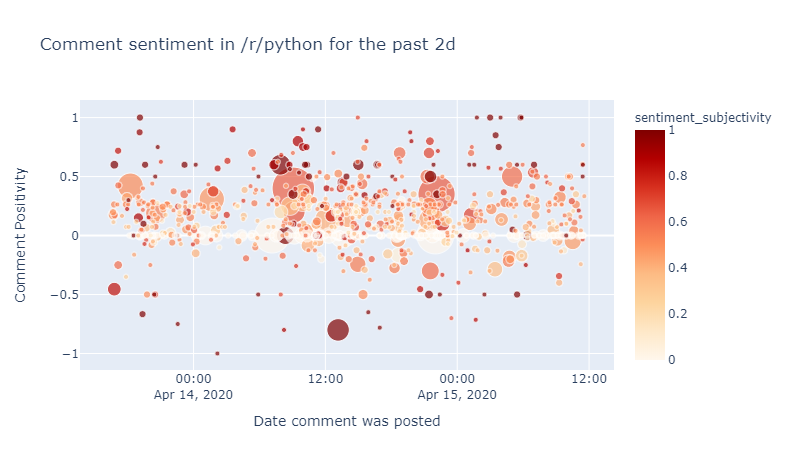

In [97]:
px.scatter(df3, x = 'date',
          y = 'sentiment_polarity',
          hover_data = ['author', 'permalink', 'preview'],
          color_continuous_scale = px.colors.sequential.OrRd,
          color = 'sentiment_subjectivity',
           size = 'score',
           size_max = 30,
           labels = {'sentiment_polarity': 'Comment Positivity', 'date': 'Date comment was posted'},
           title = f'Comment sentiment in /r/{SUBREDDIT_OF_INTEREST} for the past {TIMEFRAME}'
          )